<a href="https://colab.research.google.com/github/mehmetdursunn/Creating-synthetic-images-using--GAN/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt

170498071/170498071 [==============================] - 14s 0us/step


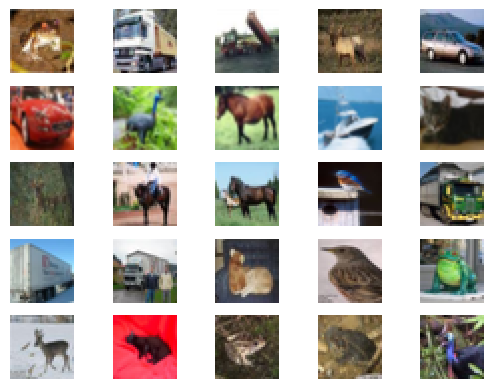

In [ ]:
(trainX, trainy), (testX, testy) = load_data()


for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [ ]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()

	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


In [ ]:
test_discr = define_discriminator()
print(test_discr.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def define_generator(latent_dim):
	model = Sequential()

	n_nodes = 128 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))
	return model


In [ ]:
test_gen = define_generator(100)
print(test_gen.summary())



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [ ]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=128):
	for i in range(n_epochs):
	  x_gan = generate_latent_points(latent_dim, n_batch)
		y_gan = ones((n_batch, 1))
		gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
    for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
		  y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

In [ ]:

def load_real_samples():
	(trainX, _), (_, _) = load_data()

	X = trainX.astype('float32')

	X = (X - 127.5) / 127.5
	return X

In [ ]:
def generate_real_samples(dataset, n_samples):

	ix = randint(0, dataset.shape[0], n_samples)

	X = dataset[ix]

	y = ones((n_samples, 1))
	return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):

	x_input = randn(latent_dim * n_samples)

	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):

	x_input = generate_latent_points(latent_dim, n_samples)

	X = generator.predict(x_input)

	y = zeros((n_samples, 1))
	return X, y

In [ ]:

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):

	X_real, y_real = generate_real_samples(dataset, n_samples)

	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))






In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)

	for i in range(n_epochs):

		for j in range(bat_per_epo):


			X_real, y_real = generate_real_samples(dataset, half_batch)

			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)


			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


			X_gan = generate_latent_points(latent_dim, n_batch)


			y_gan = ones((n_batch, 1))


			g_loss = gan_model.train_on_batch(X_gan, y_gan)


			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

	g_model.save('cifar_generator_2epochs.h5')


















In [ ]:

latent_dim = 100

discriminator = define_discriminator()

generator = define_generator(latent_dim)

gan_model = define_gan(generator, discriminator)

dataset = load_real_samples()

train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=200)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
2/2 [==============================] - 0s 8ms/step
Epoch>98, Batch 219/390, d1=0.662, d2=0.631 g=1.024
2/2 [==============================] - 0s 4ms/step
Epoch>98, Batch 220/390, d1=0.501, d2=0.491 g=1.031
2/2 [==============================] - 0s 6ms/step
Epoch>98, Batch 221/390, d1=0.654, d2=0.582 g=1.075
2/2 [==============================] - 0s 8ms/step
Epoch>98, Batch 222/390, d1=0.569, d2=0.675 g=1.050
2/2 [==============================] - 0s 7ms/step
Epoch>98, Batch 223/390, d1=0.685, d2=0.617 g=1.045
2/2 [==============================] - 0s 15ms/step
Epoch>98, Batch 224/390, d1=0.686, d2=0.539 g=1.086
2/2 [==============================] - 0s 7ms/step
Epoch>98, Batch 225/390, d1=0.672, d2=0.641 g=1.042
2/2 [==============================] - 0s 6ms/step
Epoch>98, Batch 226/390, d1=0.611, d2=0.547 g=1.010
2/2 [==============================] - 0s 12ms/step
Epoch>98, Batch 227/390, d1=0.651, d2=0.574 g=0.988
2/2 [===================

In [ ]:
def generate_latent_points(latent_dim, n_samples):

	x_input = randn(latent_dim * n_samples)

	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
from keras.models import load_model
from numpy.random import randn



def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :])
	plt.show()

1/1 [==============================] - 0s 387ms/step


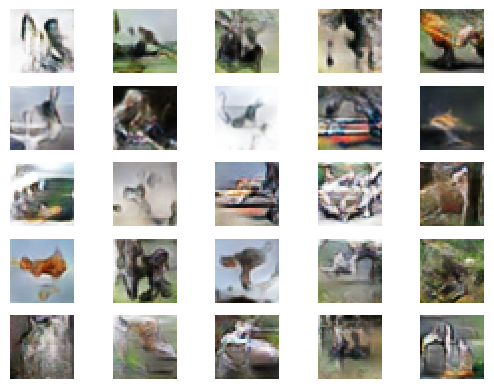

In [ ]:
model = load_model('cifar_generator_2epochs.h5',  compile=False)

latent_points = generate_latent_points(100, 25)

X = model.predict(latent_points)

X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)


show_plot(X, 5)